In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Concatenate, Flatten , BatchNormalization
from keras.optimizers import Adam
from keras.applications import VGG16, ResNet50
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import albumentations as A
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define necessary constants
TRAIN_DIR = ''
TEST_DIR = ''
IMG_SIZE = 224
CATEGORIES = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
MODEL_SAVE_PATH = ''

In [3]:
class ImagesDataset:
    def __init__(self, files, labels, transforms=None):
        self.files = files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        label = self.labels[idx]

        if self.transforms:
            augmented = self.transforms(image=img)
            img = augmented['image']

        img = img / 255.0
        return img, label

In [4]:
def create_file_label_list(directory):
    files = []
    labels = []
    for category in CATEGORIES:
        path = os.path.join(directory, category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
                files.append(img_path)
                labels.append(class_num)
            except Exception as e:
                pass
    return files, labels

In [5]:
def visualize_images(dataset):
    fig, axes = plt.subplots(1, len(CATEGORIES), figsize=(7, 4))
    for i, category in enumerate(CATEGORIES):
        category_images = [img for img, label in zip(dataset.files, dataset.labels) if label == i]
        img_path = category_images[0]  # Take the first image of each category
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if dataset.transforms:
            augmented = dataset.transforms(image=img)
            img = augmented['image']
        axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"{category}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
transforms_train = A.Compose([
    A.Rotate(limit=7, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.RandomGamma(p=0.5),
    A.OneOf([
        A.ElasticTransform(p=0.1),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(p=0.1),
    ], p=0.2),
    A.CLAHE(p=0.1),
    A.ColorJitter(p=0.1),
    A.ToGray(p=0.1),
    A.ChannelShuffle(p=0.1)
])


In [6]:
files_train, labels_train = create_file_label_list(TRAIN_DIR)
files_test, labels_test = create_file_label_list(TEST_DIR)

train_dataset = ImagesDataset(files=files_train, labels=labels_train, transforms=transforms_train)
test_dataset = ImagesDataset(files=files_test, labels=labels_test, transforms=None)


100%|██████████| 233/233 [00:00<00:00, 395496.90it/s]


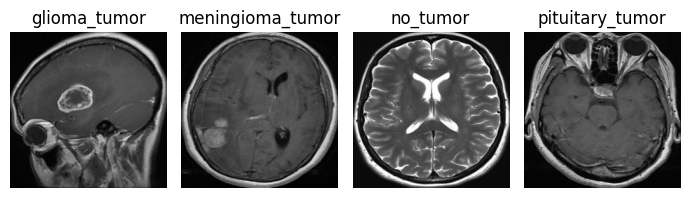

In [ ]:
visualize_images(trainNo_dataset)

In [7]:
X_train = np.array([train_dataset[i][0] for i in range(len(train_dataset))]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [8]:
Y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

In [9]:
X_test = np.array([test_dataset[i][0] for i in range(len(test_dataset))]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [10]:
Y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

In [11]:
vgg16_model = VGG16(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet50_model = ResNet50(include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))

# congelo dei layer tranne degli ultimi 4
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False
for layer in resnet50_model.layers[:-4]:
    layer.trainable = False

# output dei modelli
vgg16_output = vgg16_model.output
vgg16_output = Flatten()(vgg16_output)
vgg16_output = Dense(256, activation='relu')(vgg16_output)

resnet50_output = resnet50_model.output
resnet50_output = Flatten()(resnet50_output)
resnet50_output = Dense(256, activation='relu')(resnet50_output)

# Concatenazione degli outputs
combined_output = Concatenate()([vgg16_output, resnet50_output])

# Aggiunta layers
x = Dense(512, activation='relu')(combined_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

# Creazione del modello finale
model = Model(inputs=[vgg16_model.input, resnet50_model.input],
              outputs=output)

# Compilazione del modello creato
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
callbacks = [early_stopping]

In [ ]:
# Train the model
history = model.fit(
    [X_train, X_train], Y_train,
    validation_data=([X_test, X_test], Y_test),
    epochs=50,
    batch_size=32,
)

In [1]:
def plot_learning_curves(history):
    # Accuratezza
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    # Perdita
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_learning_curves(history)

NameError: name 'history' is not defined

In [ ]:
model.save(MODEL_SAVE_PATH)